# 1

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
#General dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# This sets GPU growth to avoid memory issues

# gpus = tf.config.experimental.list_physical_devices('GPU')

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# gpus

# No tengo GPU? XD

In [4]:
pos_dir = os.path.join("data", "positive")
neg_dir = os.path.join("data", "negative")
anc_dir = os.path.join("data", "anchor")

In [5]:
# os.makedirs(pos_dir)
# os.makedirs(neg_dir)
# os.makedirs(anc_dir)

# 2

In [6]:
# Location of training images

# http://vis-www.cs.umass.edu/lfw/#download

In [7]:
# Extracts the imgs

# !tar -xf lfw.tgz # This name is now different

In [8]:
# for directory in os.listdir("lfw"):
#     for img in os.listdir(os.path.join("lfw", directory)):
#         old_path = os.path.join("lfw", directory, img)
#         new_path = os.path.join(neg_dir, img)
#         os.replace(old_path, new_path)

In [9]:
def take_center(frame):
    #Take the 250*250 center of the shape

    x = 195 # int((frame.shape[1])/2 - (250/2))
    y = 115 # int((frame.shape[0])/2 - (250/2))

    return frame[y:y+250, x:x+250]

In [10]:
import uuid

In [11]:
# Obtain anchor and positives

# cap = cv2.VideoCapture(1) # forwards cam is 0 !!

# while cap.isOpened():
#     _, frame = cap.read()
    
#     frame = take_center(frame)    
#     cv2.imshow("Image collection", frame)
    
#     # Collect positive
#     if cv2.waitKey(1) & 0XFF == ord("p"):
#         img_name = os.path.join(pos_dir, f"{uuid.uuid1()}.jpg")
#         cv2.imwrite(img_name, frame)
#         continue
        
#     # Collect anchor
#     if cv2.waitKey(1) & 0XFF == ord("a"):
#         img_name = os.path.join(anc_dir, f"{uuid.uuid1()}.jpg")
#         cv2.imwrite(img_name, frame)
#         continue
        
#     # Close camera
#     if cv2.waitKey(1) & 0XFF == ord("q"):
#         break

# cap.release()
# cv2.destroyAllWindows()

# 3

In [12]:
anchor = tf.data.Dataset.list_files(anc_dir+"\*.jpg").take(300)
positive = tf.data.Dataset.list_files(pos_dir+"\*.jpg").take(300)
negative = tf.data.Dataset.list_files(neg_dir+"\*.jpg").take(300)

In [13]:
# (anchor, positives) --> [1. 1. 1. 1. 1.] Verified images
# (anchor, negatives) --> [0. 0. 0. 0. 0.] Unverified images

In [14]:
# Creating the labeled datasets !

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [15]:
samplescheck = data.as_numpy_iterator()

In [16]:
samplescheck.next()

(b'data\\anchor\\423c7093-95e3-11ed-aafe-a4b1c185feb6.jpg',
 b'data\\positive\\029f2e44-95e3-11ed-806e-a4b1c185feb6.jpg',
 1.0)

In [17]:
def preprocess(file_path):
    # Adjusts images from file path into jpeg format
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    
    return img

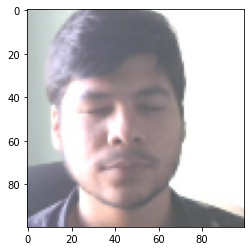

In [18]:
# How imgs look after preprocessing
plt.imshow(preprocess("C:\\Users\\Pedro\\Documents\\#1 Curso SIC\\Proyecto Final\\data\\anchor\\3d0e14a8-95e3-11ed-90d8-a4b1c185feb6.jpg"))

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
samplescheck = data.as_numpy_iterator()

1.0


<Figure size 432x288 with 0 Axes>

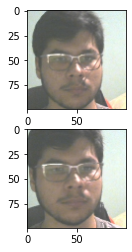

In [21]:
plt.figure()

_, axs = plt.subplots(2,1)


checky = samplescheck.next()

axs[0].imshow(preprocess(checky[0]))
axs[1].imshow(preprocess(checky[1]))

print(checky[2])

In [22]:
# Data loader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
# Training partition

train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition

test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
samples_check = train_data.as_numpy_iterator()

In [26]:
len(samples_check.next()[0])

16

# 4

In [27]:
# Build embedding layer

def make_embedding():
    input_layer = Input(shape=(100,100,3), name="Input image")
    
    # First block
    conv_layer1 = Conv2D(64, (10,10), activation="relu")(input_layer)
    maxp_layer1 = MaxPooling2D(64, (2,2), padding="same")(conv_layer1)
    
    # Second block
    conv_layer2 = Conv2D(128, (7,7), activation="relu")(maxp_layer1)
    maxp_layer2 = MaxPooling2D(64, (2,2), padding="same")(conv_layer2)
    
    # Third block
    conv_layer3 = Conv2D(128, (4,4), activation="relu")(maxp_layer2)
    maxp_layer3 = MaxPooling2D(64, (2,2), padding="same")(conv_layer3)
    
    # Final block
    conv_layer4 = Conv2D(256, (4,4), activation="relu")(maxp_layer3)
    flat1 = Flatten()(conv_layer4)
    dense1 = Dense(4096, activation="sigmoid")(flat1)
    
    
    return Model(inputs=[input_layer], outputs=[dense1], name="Embedding")  

In [28]:
embedding = make_embedding()

In [29]:
#Build distance layer

class L1Dist(Layer):
    # Inherits the "Layer" class's __init__()
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [30]:
def make_siamese_model():
    
    # Anchor image input
    input_image = Input(name="Input image", shape=(100,100,3))
    # Validation image input
    validation_image = Input(name="Validation image", shape=(100,100,3))
    
    # Combine siamese distance components
    
    siamese_layer = L1Dist()
    siamese_layer._name = "Distance"
    
    # Both streams are created AND connected down here ↓
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [31]:
siamese_model = make_siamese_model()

# 5

In [32]:
# Loss function + optimizer
# Back propagation ← ← ←
# Checkpoints
# Train step function !!!
# Training loop

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "chkpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

In [36]:
# Train step function !!

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative
        x = batch[:2]
        # Get the label
        y_true = batch[2]
        
        # Forward pass
        y_pred = siamese_model(x, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y_true, y_pred)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    

In [37]:
# Training loop

def train(data, all_epochs):
    # Loop through all epochs
    for epoch in range(1, all_epochs+1):
        print(f"\n Epoch {epoch}/{all_epochs}")
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each BATCH!
        for index, batch in enumerate(data):
            train_step(batch)
            progbar.update(index + 1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [38]:
# TRAIN TIME BABYYY

# Epochs = 50
# train(train_data, Epochs)

# <3

# 6

In [39]:
from tensorflow.keras.metrics import Precision, Recall

In [40]:
test_input, test_validation, y_true = test_data.as_numpy_iterator().next()

In [83]:
siamese_model = model

In [84]:
y_predict = siamese_model.predict([test_input, test_validation])

In [85]:
y_predict

array([[4.51695593e-13],
       [2.55170928e-12],
       [1.24808601e-11],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.09218224e-13],
       [1.00000000e+00],
       [9.99999046e-01],
       [7.53151298e-01],
       [1.00000000e+00],
       [1.25243449e-09],
       [1.00000000e+00],
       [7.63789124e-14],
       [1.00000000e+00],
       [3.74759428e-14],
       [1.00000000e+00]], dtype=float32)

In [86]:
small_pred = [1 if prediction > 0.5 else 0 for prediction in y_predict]

In [87]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [88]:
m = Recall()

m.update_state(y_true, y_predict)
m.result().numpy()

1.0

In [89]:
m = Precision()

m.update_state(y_true, y_predict)
m.result().numpy()

1.0

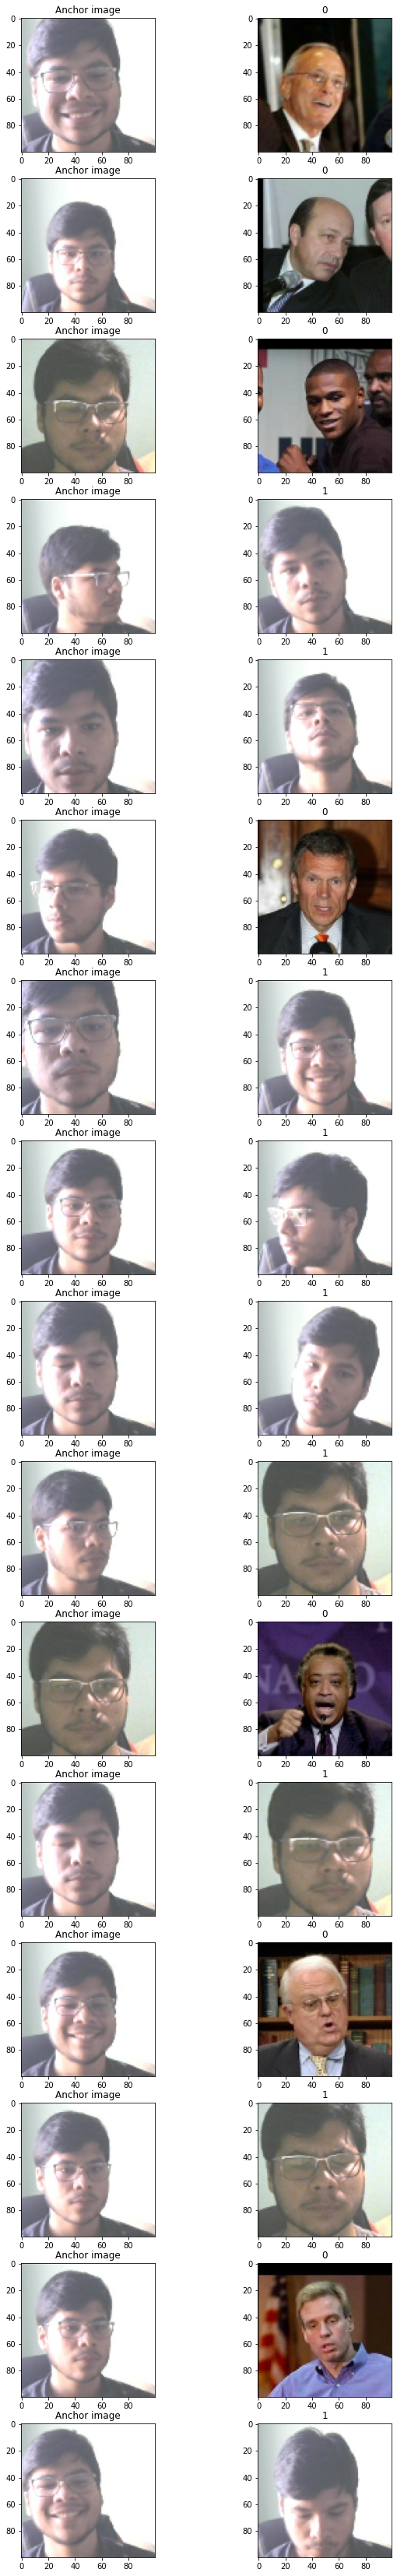

In [90]:
# print("Predicted value: ",y_predict[0][0])
batch_size = 16
_, axs = plt.subplots(batch_size,2)

for a in range(batch_size):
    axs[a][0].title.set_text("Anchor image")
    axs[a][0].imshow(test_input[a])
    axs[a][1].title.set_text(small_pred[a])
    axs[a][1].imshow(test_validation[a])

plt.gcf().set_size_inches(10, 60)
plt.show()

In [48]:
# Save weights

# siamese_model.save("SiameseModel.h5")

In [49]:
# Break in case of emergency!

# checkpoint_dir = "./training_checkpoints"
# checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)
# checkpoint.restore(manager.latest_checkpoint)

# checkpoint.siamese_model.save("SiameseModel.h5")

In [51]:
model = tf.keras.models.load_model("SiameseModel.h5",
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy}) 

# 7

In [52]:
def verify(model, detection_thresh, verification_thresh):
    
    results = []
    for img in os.listdir(os.path.join("App_data","Verification imgs")):
        input_img = preprocess(os.path.join("App_data", "Input imgs", "input_image.jpg"))
        anchor_img = preprocess(os.path.join("App_data", "Verification imgs", img))
        
        prediction = model.predict(list(np.expand_dims([input_img, anchor_img], axis=1)))
        results.append(prediction[0][0]) # Predictions are 2D, single value arrays
        
    # Detection threshold: above this, it's positive    
    detection = np.sum(np.array(results) > detection_thresh)
    
    # Verification threshold --> Positive predictions / total positives (samples)
    verification = detection / len(os.listdir(os.path.join("App_data", "Verification imgs")))
    verified = verification > verification_thresh
    
    
    return np.array(results), verified

In [77]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    
    frame = take_center(frame)
    cv2.imshow("Verification", frame)
    
    # Trigger verify
    if cv2.waitKey(10) & 0XFF == ord("v"):
        cv2.imwrite(os.path.join("App_data", "Input imgs", "input_image.jpg"), frame)
        results, verified = verify(model, 0.8, 0.8)
        print(verified)
        print(results.mean())
        continue
    
    # Close camera
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

True
0.95886815
